In [1]:
import os
import json
import numpy as np
from quinine import QuinineArgumentParser
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import copy
import matplotlib.pyplot as plt
import torch.nn.functional as F

import sys
sys.path.append('/home/jupyter/project/looped_transformer/scripts')
from nano_gpt import GPT2Model, GPT2Config

from utils import eval_unlooped_model, aggregate_metrics, eval_looped_model


In [2]:
fig_hparam = {
    'figsize': (8, 5),
    'labelsize': 28,
    'ticksize': 20,
    'linewidth': 5,
    'fontsize': 15,
    'titlesize': 20,
    'markersize': 15
}

# font specification
fontdict = {'family': 'serif',
         'size': fig_hparam['fontsize'],
         }

In [3]:
device = torch.device('cuda:0')
def get_model(model, result_dir, run_id, step, best=False):
    if best:
        model_path = os.path.join(result_dir, run_id, 'model_best.pt')
        state_dict = torch.load(model_path, map_location='cpu')['state_dict']
        best_err = torch.load(model_path, map_location='cpu')['loss']
        print("saved model with loss:", best_err)
    if step == -1:
        model_path = os.path.join(result_dir, run_id, 'state.pt')
        state_dict = torch.load(model_path, map_location='cpu')['model_state_dict']
    else:
        model_path = os.path.join(result_dir, run_id, 'model_{}.pt'.format(step))
        state_dict = torch.load(model_path, map_location='cpu')['model']
    
#     return state_dict
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict, strict=True)
    
    return model


# Get Dataset

In [4]:
class LinearRegression():
    def __init__(self, batch_size, n_points, n_dims, n_dims_truncated, device, w_star=None):
        super(LinearRegression, self).__init__()
        self.device = device
        self.xs = torch.randn(batch_size, n_points, n_dims).to(device)
        self.xs[..., n_dims_truncated:] = 0
        w_b = torch.randn(batch_size, n_dims, 1) if w_star is None else w_star.to(device)  # [B, d, 1]
        w_b[:, n_dims_truncated:] = 0
        self.w_b = w_b.to(device)
        self.ys = (self.xs @ self.w_b).sum(-1)  # [B, n]
        
sample_size = 1280
batch_size = 128
n_points = 41
n_dims_truncated = 20
n_dims = 20

real_task = LinearRegression(sample_size, n_points, n_dims, n_dims_truncated, device)
xs, ys, w_b = real_task.xs, real_task.ys, real_task.w_b

# Load unlooped Model

In [10]:
result_dir = '/home/jupyter/project/looped_transformer/results2/phop_baseline_loop/'
run_id = '0614230044-LR_loop_L1_ends{12}_T{5}-a013'

from models import TransformerModelLoopedWithEmbLayer

n_dims = 20
n_positions = 101
n_embd = 256
n_layer = 1
n_head = 8
pred_type = 'classification'  # 'regression' or 'classification'

model = TransformerModelLoopedWithEmbLayer(n_dims, n_positions, n_embd, n_layer, n_head, pred_type=pred_type)
step = 10000
model = get_model(model, result_dir, run_id, step)
model = model.to(device)


number of parameters: 0.79M


/var/tmp/ipykernel_251492/2205471420.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location='cpu')['model']


In [11]:
model.eval()

TransformerModelLoopedWithEmbLayer(
  (emb_layer): Embedding(17, 256)
  (_read_in): Linear(in_features=256, out_features=256, bias=True)
  (_backbone): GPT2Model(
    (transformer): ModuleDict(
      (wpe): Embedding(278, 256)
      (drop): Dropout(p=0.0, inplace=False)
      (h): ModuleList(
        (0): Block(
          (ln_1): LayerNorm()
          (attn): CausalSelfAttention(
            (c_attn): Linear(in_features=256, out_features=768, bias=True)
            (c_proj): Linear(in_features=256, out_features=256, bias=True)
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
          )
          (ln_2): LayerNorm()
          (mlp): MLP(
            (c_fc): Linear(in_features=256, out_features=1024, bias=True)
            (c_proj): Linear(in_features=1024, out_features=256, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm()
    )
  )
  (_read_out): Li

## Load looped transformer with T=5, b=12, Random W_b

In [7]:
from models import TransformerModelLooped

result_dir = '../results2/linear_regression_loop'
run_id = '0524072558-LR_loop_L1_ends{12}_T{5}-3b39'

n_positions = 101
n_embd = 256
n_head = 8
T = 500
n_layer = 1

model = TransformerModelLooped(n_dims, n_positions, n_embd, n_layer, n_head)
step = -1
model = get_model(model, result_dir, run_id, step)
model = model.to(device)
    
err, loop_err = eval_looped_model(model, xs, ys, loop_max=T)

result_errs['Looped Transformer Random W_B'] = err

number of parameters: 0.79M
0


/var/tmp/ipykernel_3284862/2205471420.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location='cpu')['model_state_dict']


## Load looped transformer with fixed W_b

In [8]:
from models import TransformerModelLooped

result_dir = '../results2/linear_regression_loop'
run_id = '0520050529-LR_loop_L1_ends{12}_T{5}-4b70'

n_positions = 101
n_embd = 256
n_head = 8
T = 500
n_layer = 1

model = TransformerModelLooped(n_dims, n_positions, n_embd, n_layer, n_head)
step = -1
model = get_model(model, result_dir, run_id, step)
model = model.to(device)
    
err, loop_err = eval_looped_model(model, xs, ys, loop_max=T)

result_errs['Looped Transformer Fixed W_B'] = err

number of parameters: 0.79M
0


/var/tmp/ipykernel_3284862/2205471420.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location='cpu')['model_state_dict']


## Load looped transformer with different T=15 and B=12

In [9]:
from models import TransformerModelLooped

result_dir = '../results2/linear_regression_loop'
run_id = '0525030251-LR_loop_L1_ends{12}_T{15}-3807'

n_positions = 101
n_embd = 256
n_head = 8
T = 500
n_layer = 1

model = TransformerModelLooped(n_dims, n_positions, n_embd, n_layer, n_head)
step = -1
model = get_model(model, result_dir, run_id, step)
model = model.to(device)
    
err, loop_err = eval_looped_model(model, xs, ys, loop_max=T)

result_errs['Looped Transformer B12T15'] = err

number of parameters: 0.79M
0


/var/tmp/ipykernel_3284862/2205471420.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location='cpu')['model_state_dict']


## Load looped transformer with T=5 and B=30

In [10]:
from models import TransformerModelLooped

result_dir = '../results2/linear_regression_loop'
run_id = '0524191803-LR_loop_L1_ends{30}_T{5}-33f4'

n_positions = 101
n_embd = 256
n_head = 8
T = 500
n_layer = 1

model = TransformerModelLooped(n_dims, n_positions, n_embd, n_layer, n_head)
step = -1
model = get_model(model, result_dir, run_id, step)
model = model.to(device)
    
err, loop_err = eval_looped_model(model, xs, ys, loop_max=T)

result_errs['Looped Transformer B30T5'] = err

number of parameters: 0.79M
0


/var/tmp/ipykernel_3284862/2205471420.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location='cpu')['model_state_dict']


## Load Looped Transformer with T=5, b=50

In [15]:
from models import TransformerModelLooped

result_dir = '../results2/linear_regression_loop'
run_id = '0526165732-LR_loop_L1_ends{50}_T{5}-a3bf'

n_positions = 101
n_embd = 256
n_head = 8
T = 500
n_layer = 1

model = TransformerModelLooped(n_dims, n_positions, n_embd, n_layer, n_head)
step = -1
model = get_model(model, result_dir, run_id, step)
model = model.to(device)
    
err, loop_err = eval_looped_model(model, xs, ys, loop_max=T)

result_errs['Looped Transformer B50T5'] = err

number of parameters: 0.79M
0


/var/tmp/ipykernel_3284862/2205471420.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location='cpu')['model_state_dict']


## Also get the "weak" baseline

In [16]:
from utils import get_relevant_baselines

baselines = get_relevant_baselines("linear_regression")
# baseline_errs = {}
for baseline_model in baselines:
    y_pred = baseline_model(xs, ys)
    err = (y_pred.cpu() - ys.cpu()).square()
    result_errs[baseline_model.name] = err
    

In [17]:
result_errs_agg = aggregate_metrics(result_errs, n_dims_truncated)

In [18]:
result_errs_agg.keys()

dict_keys(['Transformer', 'Looped Transformer Random W_B', 'Looped Transformer Fixed W_B', 'Looped Transformer B12T15', 'Looped Transformer B30T5', 'Least Squares', '3-Nearest Neighbors', 'Averaging', 'Looped Transformer B50T5'])

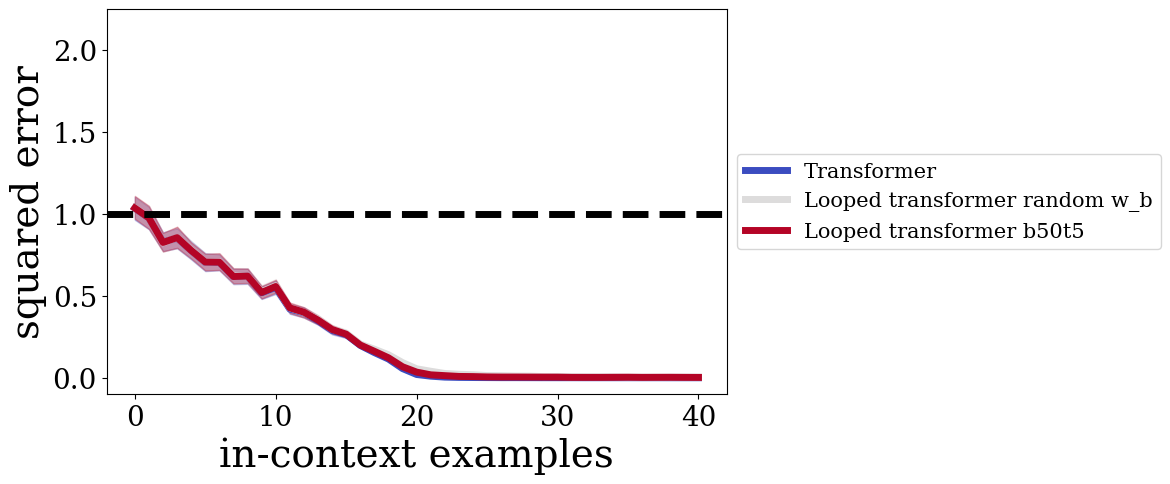

In [22]:
import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots(1, figsize=fig_hparam['figsize'])

err_result_dict_agg = result_errs_agg

cmap = matplotlib.cm.get_cmap("coolwarm")
result_name_list = ['Transformer', 'Looped Transformer Random W_B', 'Looped Transformer B50T5']  # , 
colors = cmap(np.linspace(0, 1, len(result_name_list)))
for idx, model_name in enumerate(result_name_list):
    err = err_result_dict_agg[model_name]["mean"]
    ax.plot(err, color=colors[idx], lw=fig_hparam['linewidth'], label=model_name.capitalize())
    low = err_result_dict_agg[model_name]["bootstrap_low"]
    high = err_result_dict_agg[model_name]["bootstrap_high"]
    ax.fill_between(range(len(low)), low, high, alpha=0.3, color=colors[idx])

ax.tick_params(axis='both', labelsize=fig_hparam['ticksize'])
ax.axhline(1, color='k', ls='--', lw=fig_hparam['linewidth'])
ax.set_ylim(-0.1, 2.25)
# plt.xticks(np.arange(0, n_points))
plt.rc('font', family='serif')
ax.set_xlabel("in-context examples", fontsize=fig_hparam['labelsize'])
y_label = ax.set_ylabel("squared error", fontsize=fig_hparam['labelsize'])
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fig_hparam['fontsize'])


# plt.savefig("result_folder/Figures/LR_err.pdf", format='pdf', dpi=600, bbox_inches='tight')